In [10]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

In [2]:
def _stereo_to_mono(waveform: torch.Tensor) -> torch.Tensor:
    """Converts a stereo waveform to mono

    Parameters
    ----------
    waveform : torch.Tensor
        Stereo waveform to convert.

    Returns
    -------
    torch.Tensor
        Mono converted waveform.
    """

    if waveform.shape[0] > 1:
        return(torch.mean(waveform, dim=0, keepdim=True))

In [3]:
sample, rate = torchaudio.load('data/raw/hi-hat_001.wav')
sample.shape

torch.Size([2, 4566])

In [4]:
resample = T.Resample(orig_freq=41000, new_freq=16000)
resampled = resample(sample)
resampled.shape

torch.Size([2, 1782])

In [5]:
mono = _stereo_to_mono(resampled)
mono.shape

torch.Size([1, 1782])

In [6]:
chunk_length = 160
splits = torch.split(mono.squeeze(0), chunk_length)
splits[-1].unsqueeze(0).shape

torch.Size([1, 22])

In [7]:
splits[-1].shape

torch.Size([22])

In [8]:
str(1).zfill(3)

'001'

In [12]:
def plot_waveform(signal, rate=44100, title='Waveform', ax=None):
    signal = signal.numpy()
    n_channels, n_frames = signal.shape
    time_axis = torch.arange(0, n_frames) / rate

    if ax == None:
        ax = plt.gca()
    ax.plot(time_axis, signal[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

In [33]:
sample, rate = torchaudio.load('data/clean/hi-hat_694.wav')
torch.mean(sample.squeeze(0))

tensor(-0.0005)

In [41]:
sample.shape

torch.Size([1, 160])

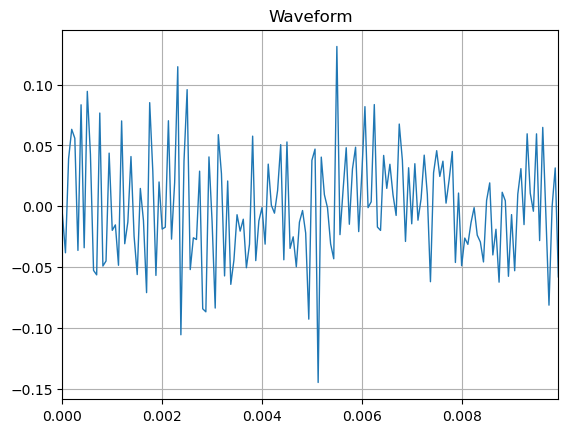

In [35]:
plot_waveform(sample, rate)

In [40]:
transform = T.AmplitudeToDB(stype="amplitude", top_db=80)
sample_db = transform(sample)
float(torch.mean(sample_db.squeeze(0)))

-67.08177947998047

In [47]:
len(sample_db.shape)

2

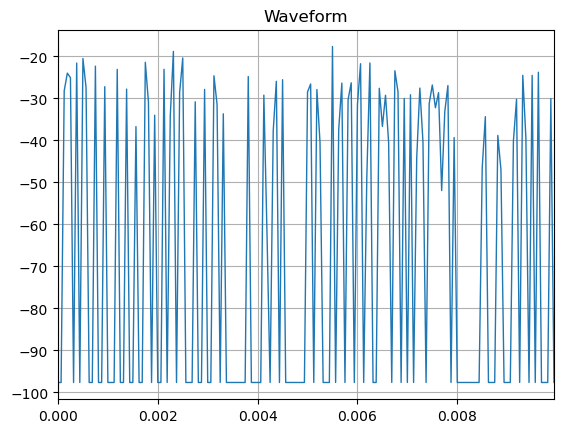

In [39]:
plot_waveform(sample_db, rate)